# AirBnB Price Prediction

### Introduction/Background
NYC has the second most available AirBnB listings in the US. It's a common destination for vacations, work trips, and other excursions making it a great data source for the app. New York presents a contained microcosm of AirBnB that's representative of many metropolis destinations around the world. 

This notebook will analyze the factors that affect cost of an AirBnb within New York City.

### Importing Data
I'll use an overkill method for efficiently loading our data. This changes the datatypes to be much smaller than Pandas large default datatypes and will occupy less system memory while we excute this notebook.

In [36]:
import re
import random
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook

from sklearn.model_selection import train_test_split

In [37]:
bnb_path = "../data/AB_NYC_2019.csv"

df_tmp = pd.read_csv(
    bnb_path,
    nrows=5
)

traintypes = {
    'id': 'int32',
    'name': 'str',
    'host_id': 'int32',
    'host_name': 'str',
    'neighbourhood_group': 'str',
    'neighbourhood': 'str',
    'latitude': 'float32',
    'longitude': 'float32',
    'room_type': 'str',
    'price': 'uint16',
    'minimum_nights': 'uint16',
    'number_of_reviews': 'uint16',
    'last_review': 'str',
    'reviews_per_month': 'float16',
    'calculated_host_listings_count': 'uint16',
    'availability_365': 'uint16',
}

df_list = []

chunksize = 1_000_000

for df_chunk in pd.read_csv(
        bnb_path, 
        dtype=traintypes, 
        chunksize=chunksize
    ):

    df_chunk['last_review'] = df_chunk['last_review'].str.slice(0, 16)
    df_chunk['last_review'] = pd.to_datetime(df_chunk['last_review'], utc=True, format='%Y-%m-%d %H:%M')
    
    df_list.append(df_chunk)
    
bnb_df = pd.concat(df_list[0:1])
bnb_df = bnb_df[~bnb_df.isin([np.nan, np.inf, -np.inf]).any(1)]

del df_list

bnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.647491,-73.972366,Private room,149,1,9,2018-10-19 00:00:00+00:00,0.209961,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.753620,-73.983772,Entire home/apt,225,1,45,2019-05-21 00:00:00+00:00,0.379883,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.685139,-73.959763,Entire home/apt,89,1,270,2019-07-05 00:00:00+00:00,4.640625,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.798512,-73.943993,Entire home/apt,80,10,9,2018-11-19 00:00:00+00:00,0.099976,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.747669,-73.974998,Entire home/apt,200,3,74,2019-06-22 00:00:00+00:00,0.589844,1,129


We've got a fair amount of features that we might be able to use to predict price here. Let's see how they all correlate with price.

### Quantitative Analysis
Since we're trying to predict price let's plot some of the numerical features against price and see if we can find anything. We'll also compute correlation with price.

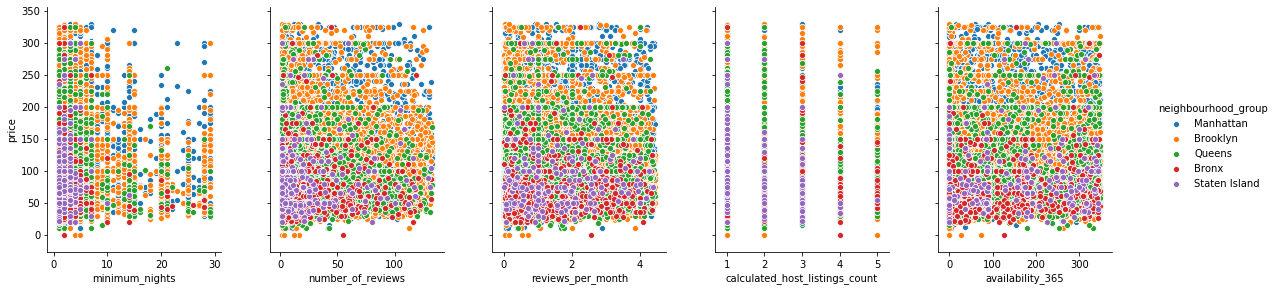

In [38]:
remove_outliers = True

pair_cols = [
    "neighbourhood_group",
    "price",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365"
]

pair_df = bnb_df[pair_cols]

if remove_outliers:
    
    for feature in pair_cols[1:]:
        outlier_value = np.percentile(pair_df[feature].values, 95)
        pair_df = pair_df[pair_df[feature] < outlier_value]

pair_plot = sns.pairplot(data=pair_df, y_vars=["price"], x_vars=pair_cols[2:], hue="neighbourhood_group")
pair_plot.fig.set_size_inches(18,5)

In [39]:
pair_df[pair_cols].corr()["price"]

price                             1.000000
minimum_nights                   -0.008526
number_of_reviews                 0.019129
reviews_per_month                 0.012843
calculated_host_listings_count   -0.171011
availability_365                  0.039794
Name: price, dtype: float64

Price is most likely affected by geography and thus can be split out by each borough in NYC. 

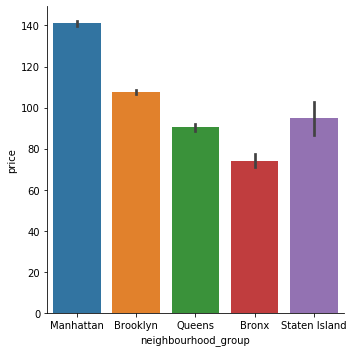

In [40]:
sns.catplot(x="neighbourhood_group", y="price", kind="bar", data=pair_df);

### Verbal Analysis
There doesn't seem to be much correlation between any of the features in our dataset with price outright. We'll try some feature engineering later and see if we can't find good quantifiable predictors of price, but in the meantime I'm curious about the effect of the description of the AirBnb on price.

The first thing we'll do is create a list of unique words used in the listing names after cleaning the names feature a bit.

In [41]:
bad_chars = [
    "\(",
    "\)",
    "(",
    ")",
    "\*",
    "_",
    "&",
    "]",
    "[",
    "+",
    "|",
    ":",
    "{",
    "}",
    "-",
]

bnb_df["name"] = bnb_df["name"].str.lower()

for char in bad_chars:
    bnb_df["name"] = bnb_df["name"].str.replace(char, "")

word_dist = bnb_df.name.str.split(expand=True).stack().value_counts()

stop_words = [
    "in",
    "to",
    "1",
    "2",
    "3",
    "4"
    "of",
    "the",
    "with",
    "and",
    "from",
    "near",
    "a",
    "for",
    "w/",
    "bed",
]

for word, count in word_dist.items():
    if word in stop_words or count < 5:
        del word_dist[word]
                
word_dist.head()

room         7633
private      5836
bedroom      5668
apartment    4869
cozy         3894
dtype: int64

In [42]:
word_list = word_dist.keys()
word_counts = word_dist.values

word_list = ["{}_{}".format(word,count) for word, count in word_dist.items()]

print("There were {} unique words used to describe {} AirBnBs".format(len(word_dist),bnb_df.shape[0]))
print("On average each AirBnB had %.2f unique words" % (bnb_df.shape[0] / len(word_dist)))

There were 2154 unique words used to describe 38821 AirBnBs
On average each AirBnB had 18.02 unique words


In [43]:
word_price_medians = []

low_price_thresh  = np.percentile(bnb_df["price"], 30)
high_price_thresh = np.percentile(bnb_df["price"], 70)

median_price_thresh = np.percentile(bnb_df["price"], 50)

very_low_price_thresh  = np.percentile(bnb_df["price"], 1)
very_high_price_thresh = np.percentile(bnb_df["price"], 99)

print("Overall median AirBnB price in NYC: $%.2f" % (bnb_df["price"].median()))

print("30th percentile of prices: {}".format(low_price_thresh))
print("70th percentile of prices: {}".format(high_price_thresh))

for word in word_list:
    word = word.split("_")[0]
    df_slice = bnb_df[bnb_df["name"].str.contains(word)]
    word_price_medians.append(df_slice["price"].median())

word_price_medians = np.array(word_price_medians)

Overall median AirBnB price in NYC: $101.00
30th percentile of prices: 75.0
70th percentile of prices: 150.0


### Words That Cause Prices Far from Mean

Number of lower than average AirBnb listing prices: 329


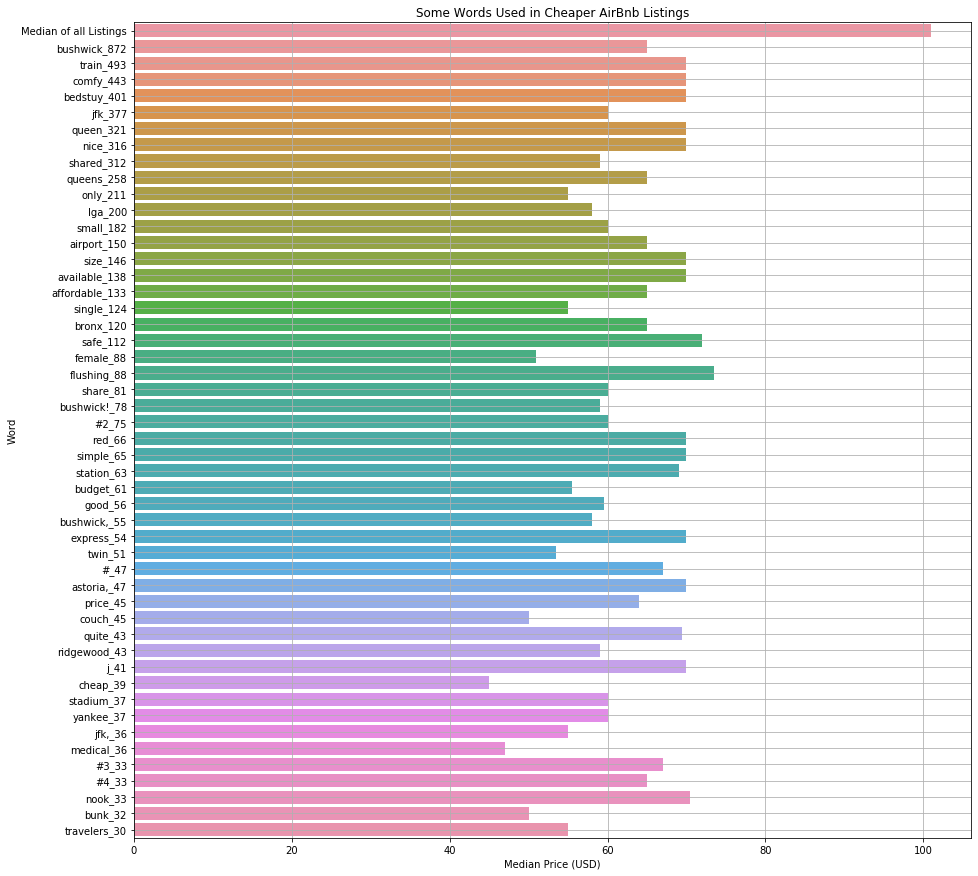

In [44]:
cheap_words = ["Median of all Listings"]
cheap_means = [median_price_thresh]

for price_ix, price in enumerate(word_price_medians):
    if price < low_price_thresh:
        cheap_words.append(word_list[price_ix])
        cheap_means.append(price)

random.seed(datetime.now())
random.shuffle(cheap_words[1:])

print("Number of lower than average AirBnb listing prices: {}".format(len(cheap_means)-1))
        
num_cheap_words = 50        

plt.figure(figsize=(15,15))

ax = sns.barplot(cheap_means[:num_cheap_words], cheap_words[:num_cheap_words])

plt.xlabel("Median Price (USD)")
plt.ylabel("Word")
plt.grid("on")
plt.title("Some Words Used in Cheaper AirBnb Listings")
plt.show()

Number of higher than average AirBnb listing prices: 413


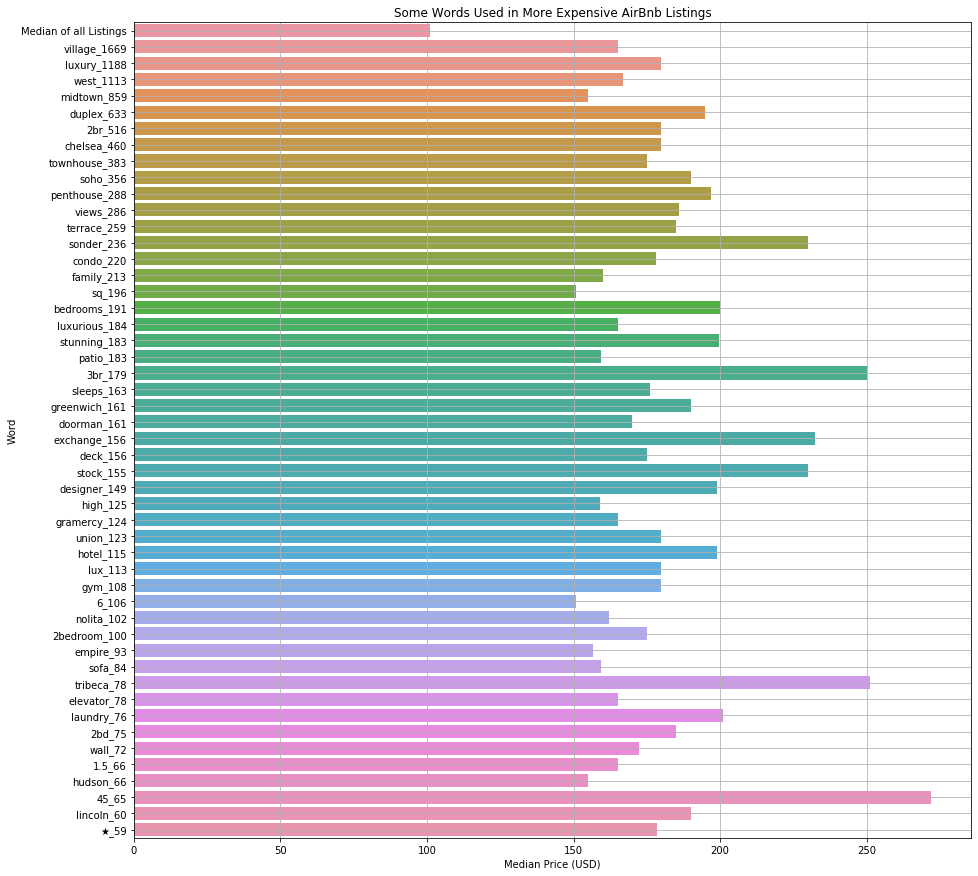

In [45]:
rich_words = ["Median of all Listings"]
rich_means = [median_price_thresh]

for price_ix, price in enumerate(word_price_medians):
    if price > high_price_thresh:
        rich_words.append(word_list[price_ix])
        rich_means.append(price)
        
random.seed(datetime.now())
random.shuffle(rich_words[1:])
        
print("Number of higher than average AirBnb listing prices: {}".format(len(rich_means)-1))
    
num_rich_words = 50        

plt.figure(figsize=(15,15))

ax = sns.barplot(rich_means[:num_rich_words], rich_words[:num_rich_words])

plt.xlabel("Median Price (USD)")
plt.ylabel("Word")
plt.grid("on")
plt.title("Some Words Used in More Expensive AirBnb Listings")
plt.show()

In [46]:
cheap_df = bnb_df[bnb_df["price"] > high_price_thresh]
rich_df  = bnb_df[bnb_df["price"] < low_price_thresh]

dirt_df  = bnb_df[bnb_df["price"] < very_low_price_thresh]
elite_df = bnb_df[bnb_df["price"] > very_high_price_thresh]

free_df = bnb_df[bnb_df["price"] == 0]

### Outlier Analysis

In [54]:
num_free = free_df.shape[0]
num_dirt = dirt_df.shape[0]
num_elite = elite_df.shape[0]

random_free_ix = random.randint(0,num_free-1)
random_dirt_ix = random.randint(0,num_dirt-1)
random_elite_ix = random.randint(0,num_elite-1)

print("Number of super cheap listings: {}".format(num_dirt))
print("Number of super expensive listings: {}".format(num_elite))

print("\nRandom Super Cheap AirBnb Listing: ")
print("Name: {}".format(dirt_df["name"].iloc[random_dirt_ix]))
print("Price: {}".format(dirt_df["price"].iloc[random_dirt_ix]))

print("\nRandom Super Expensive AirBnb Listing: ")
print("Name: {}".format(elite_df["name"].iloc[random_elite_ix]))
print("Price: {}".format(elite_df["price"].iloc[random_elite_ix]))

print("\nRandom Free AirBnb Listing: ")
print("Name: {}".format(free_df["name"].iloc[random_free_ix]))
print("Price: Free")

Number of super cheap listings: 309
Number of super expensive listings: 389

Random Super Cheap AirBnb Listing: 
Name: sunny, quiet room in greenpoint
Price: 0

Random Super Expensive AirBnb Listing: 
Name: amazing views 3br 2ba bright and spacious
Price: 999

Random Free AirBnb Listing: 
Name: coliving in brooklyn! modern design / shared room
Price: Free


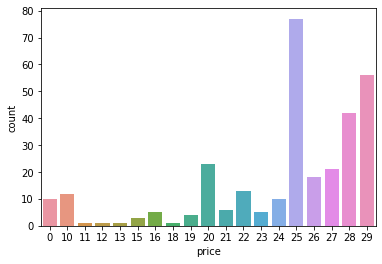

In [48]:
sns.countplot(dirt_df["price"])

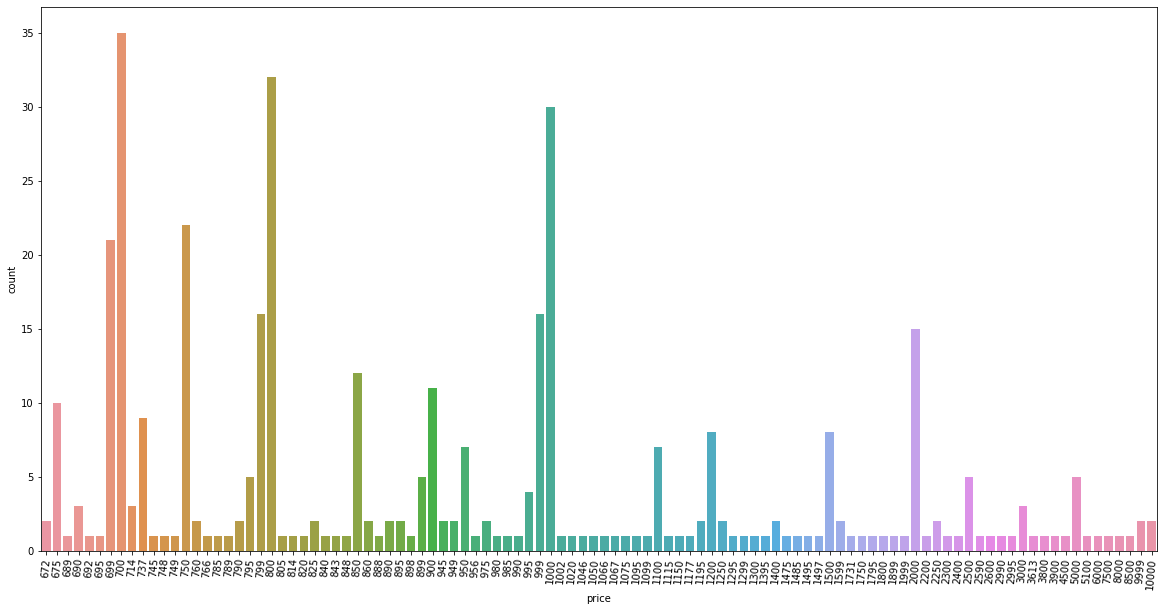

In [49]:
plt.figure(figsize=(20,10))
sns.countplot(elite_df["price"])
ticks = plt.xticks(rotation=85)